### --- Baseline ---

In [10]:
print(df.columns.tolist())

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']


⚠️  Loaded ../data/processed/stocks_news_merged.csv
✅ Using sentiment column: avg_sentiment_score → avg_sentiment_score
Epoch 1/25 | Loss: 0.6936
Epoch 2/25 | Loss: 0.6875
Epoch 3/25 | Loss: 0.6897
Epoch 4/25 | Loss: 0.6886
Epoch 5/25 | Loss: 0.6908
Epoch 6/25 | Loss: 0.6908
Epoch 7/25 | Loss: 0.6917
Epoch 8/25 | Loss: 0.6921
Epoch 9/25 | Loss: 0.6890
Epoch 10/25 | Loss: 0.6892
Epoch 11/25 | Loss: 0.6934
Epoch 12/25 | Loss: 0.6893
Epoch 13/25 | Loss: 0.6938
Epoch 14/25 | Loss: 0.6880
Epoch 15/25 | Loss: 0.6933
Epoch 16/25 | Loss: 0.6874
Epoch 17/25 | Loss: 0.6898
Epoch 18/25 | Loss: 0.6917
Epoch 19/25 | Loss: 0.6861
Epoch 20/25 | Loss: 0.6875
Epoch 21/25 | Loss: 0.6915
Epoch 22/25 | Loss: 0.6901
Epoch 23/25 | Loss: 0.6861
Epoch 24/25 | Loss: 0.6843
Epoch 25/25 | Loss: 0.6896

Baseline LSTM Accuracy: 0.5398230088495575
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.54      1.00      0.70        61

    ac

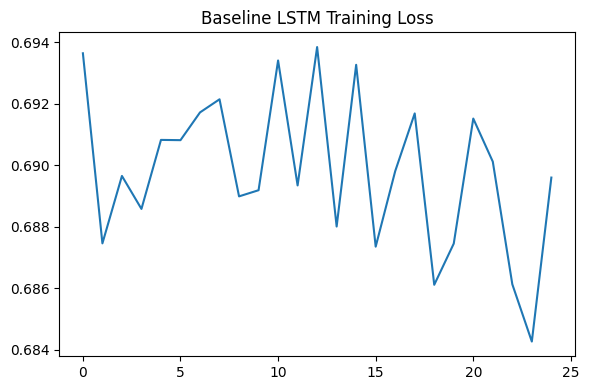

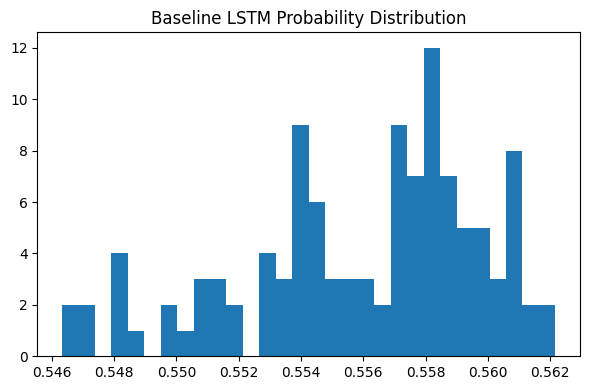

In [11]:
# ================================================================
# 06_lstm_model.ipynb — Baseline LSTM (small, for comparison)
# ================================================================

# -----------------------------
# 0) Imports & Reproducibility
# -----------------------------
import os, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -----------------------------
# 1) Load processed dataset
#    (prefers cleaned file; falls back to merged)
# -----------------------------
try:
    df = pd.read_csv("../data/processed/stock_news_merged.csv")
    print("✅ Loaded ../data/processed/stock_news_merged.csv")
except FileNotFoundError:
    df = pd.read_csv("../data/processed/stocks_news_merged.csv")
    print("⚠️  Loaded ../data/processed/stocks_news_merged.csv")

df["Date"] = pd.to_datetime(df["Date"])

# Auto-detect sentiment column and standardize its name
possible_sent_cols = [
    "avg_sentiment_score", "sentiment_score", "daily_sentiment",
    "sentiment_mean", "compound"
]
found = next((c for c in possible_sent_cols if c in df.columns), None)
if not found:
    raise KeyError("No sentiment column found. Expected one of: " + ", ".join(possible_sent_cols))
df = df.rename(columns={found: "avg_sentiment_score"})
print(f"✅ Using sentiment column: {found} → avg_sentiment_score")

# Ensure core columns exist/are computed
if "Return" not in df.columns:
    df["Return"] = df.groupby("Ticker")["Close"].pct_change()

# -----------------------------
# 2) Minimal feature set (baseline)
# -----------------------------
# Lag sentiment to avoid lookahead
df["Sentiment_lag1"] = df.groupby("Ticker")["avg_sentiment_score"].shift(1)
# Daily direction target
df["UpDown"] = (df["Return"] > 0).astype(int)

# Keep rows with everything needed
base_cols = ["Sentiment_lag1", "UpDown"]
df_b = df.dropna(subset=base_cols).copy()

# Features/target
X = df_b[["Sentiment_lag1"]].values
y = df_b["UpDown"].values

# -----------------------------
# 3) Scale + make sequences
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

SEQ_LEN = 15  # 3 trading weeks worked well for baseline tests

def make_sequences(X_, y_, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X_) - seq_len):
        Xs.append(X_[i:i+seq_len])
        ys.append(y_[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y)

# Time-ordered split (no shuffle)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# -----------------------------
# 4) PyTorch loaders
# -----------------------------
class SeqDS(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return torch.tensor(self.X[i], dtype=torch.float32), torch.tensor(self.y[i], dtype=torch.float32)

train_loader = DataLoader(SeqDS(X_train, y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(SeqDS(X_test,  y_test ), batch_size=32, shuffle=False)

# -----------------------------
# 5) Small LSTM (baseline)
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden=64, layers=2, drop=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, layers, batch_first=True, dropout=drop)
        self.fc   = nn.Sequential(nn.Linear(hidden, 32), nn.ReLU(), nn.Dropout(0.3), nn.Linear(32, 1), nn.Sigmoid())
    def forward(self, x):
        out, _ = self.lstm(x)          # (B, T, H)
        out = out[:, -1, :]            # last time step (B, H)
        return self.fc(out)            # (B, 1) in [0..1]

model = LSTMModel(input_dim=X_train.shape[2])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

# -----------------------------
# 6) Train
# -----------------------------
EPOCHS = 25
train_losses = []
for ep in range(EPOCHS):
    model.train(); total = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        p = model(Xb).squeeze()
        loss = criterion(p, yb)
        loss.backward(); optimizer.step()
        total += loss.item()
    train_losses.append(total/len(train_loader))
    print(f"Epoch {ep+1}/{EPOCHS} | Loss: {train_losses[-1]:.4f}")

# -----------------------------
# 7) Evaluate + plots
# -----------------------------
model.eval()
with torch.no_grad():
    probs = []
    for Xb, _ in test_loader:
        probs.extend(model(Xb).squeeze().numpy())
probs = np.array(probs)
preds = (probs > 0.5).astype(int)

print("\nBaseline LSTM Accuracy:", accuracy_score(y_test[:len(preds)], preds))
print(classification_report(y_test[:len(preds)], preds, zero_division=0))

plt.figure(figsize=(6,4)); plt.plot(train_losses); plt.title("Baseline LSTM Training Loss"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,4)); plt.hist(probs, bins=30); plt.title("Baseline LSTM Probability Distribution"); plt.tight_layout(); plt.show()


#### --- Feature Engineering ---

In [16]:
# =========================================
# Improved LSTM (Stable v2)
# =========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# -------------------------
# 1. Load and preprocess
# -------------------------
df = pd.read_csv("../data/processed/stocks_news_merged.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"])

# Price features
df["Return"] = df.groupby("Ticker")["Close"].pct_change()
df["Return_lag1"] = df.groupby("Ticker")["Return"].shift(1)
df["Volatility"] = df.groupby("Ticker")["Return"].rolling(5).std().reset_index(0, drop=True)

# Sentiment features
df["Sentiment_lag1"] = df.groupby("Ticker")["avg_sentiment_score"].shift(1)
df["Sentiment_ma3"]  = df.groupby("Ticker")["avg_sentiment_score"].rolling(3).mean().reset_index(0, drop=True)
df["Sentiment_diff"] = df.groupby("Ticker")["avg_sentiment_score"].diff(1)
df["Sentiment_vol_interaction"] = df["avg_sentiment_score"] * df["Volatility"]

# Target
df["UpDown"] = (df["Return"] > 0).astype(int)

feature_cols = [
    "Sentiment_lag1", "Sentiment_ma3", "Sentiment_diff",
    "Return_lag1", "Volatility", "Sentiment_vol_interaction"
]
df = df.dropna(subset=feature_cols + ["UpDown"]).copy()

#### --- Sequence Scaling ---

In [17]:
# -------------------------
# 2. Scale & sequence data
# -------------------------
scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols])
y = df["UpDown"].values

SEQ_LEN = 25
def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X, y, SEQ_LEN)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

#### --- Torch dataset + model ---

In [18]:
# -------------------------
# 3. Torch dataset + model
# -------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.tensor(self.X[i], dtype=torch.float32), torch.tensor(self.y[i], dtype=torch.float32)

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=32, shuffle=False)

class ImprovedLSTMv2(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

#### --- Model + Training ---

In [19]:
# -------------------------
# 4. Training
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImprovedLSTMv2(input_dim=X_train.shape[2]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

EPOCHS = 40
train_losses = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_losses[-1]:.4f}")


Epoch 5/40 | Loss: 0.6894
Epoch 10/40 | Loss: 0.6880
Epoch 15/40 | Loss: 0.6725
Epoch 20/40 | Loss: 0.6603
Epoch 25/40 | Loss: 0.6417
Epoch 30/40 | Loss: 0.6272
Epoch 35/40 | Loss: 0.5987
Epoch 40/40 | Loss: 0.5926


#### --- Evaluation + Plots ---

Improved LSTM (Stable v2) Accuracy: 0.5545454545454546
              precision    recall  f1-score   support

           0       0.51      0.52      0.51        50
           1       0.59      0.58      0.59        60

    accuracy                           0.55       110
   macro avg       0.55      0.55      0.55       110
weighted avg       0.56      0.55      0.55       110



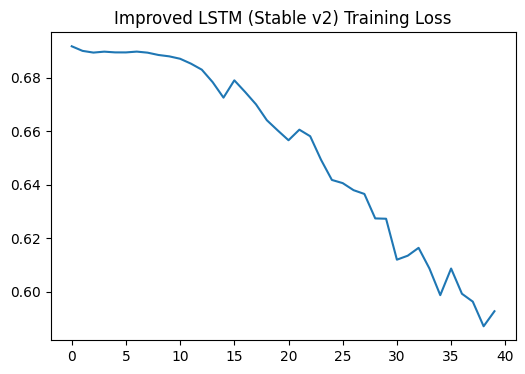

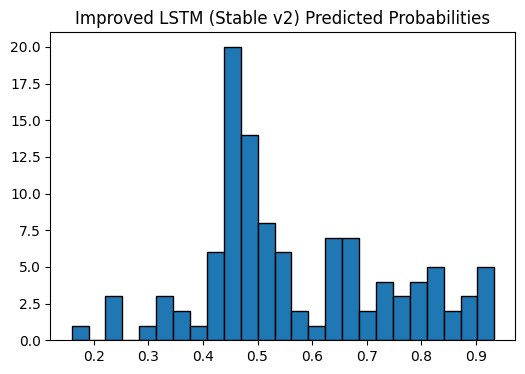

In [20]:
# -------------------------
# 5. Evaluation
# -------------------------
model.eval()
pred_probs = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        pred_probs.extend(model(xb).squeeze().cpu().numpy())

pred_probs = np.array(pred_probs)
preds = (pred_probs > 0.5).astype(int)

print("Improved LSTM (Stable v2) Accuracy:", accuracy_score(y_test[:len(preds)], preds))
print(classification_report(y_test[:len(preds)], preds, zero_division=0))

plt.figure(figsize=(6,4))
plt.plot(train_losses)
plt.title("Improved LSTM (Stable v2) Training Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(pred_probs, bins=25, edgecolor='black')
plt.title("Improved LSTM (Stable v2) Predicted Probabilities")
plt.show()